In [13]:
# ============
# 0. 공통 설정
# ============
import os
import json
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = False

BASE_DIR = "/data/ephemeral/home"
TESTDATA_DIR = os.path.join(BASE_DIR, "testdata")
DATASET_DIR = os.path.join(BASE_DIR, "dataset")

CSV_PATHS = {
    "yolo12x":       os.path.join(TESTDATA_DIR, "yolo12x.csv"),
    "rfdetr":        os.path.join(TESTDATA_DIR, "rfdetr.csv"),
    "deimv2":        os.path.join(TESTDATA_DIR, "deimv2.csv"),
    "swin_cascade":  os.path.join(TESTDATA_DIR, "swin_cascade.csv"),
}

TEST_JSON_PATH = os.path.join(DATASET_DIR, "test.json")

# %%test.json 로드 셀
with open(TEST_JSON_PATH, "r", encoding="utf-8") as f:
    test_meta = json.load(f)

image_meta = {
    img["file_name"]: {
        "width": img["width"],
        "height": img["height"],
        "id": img["id"],
    }
    for img in test_meta["images"]
}

len(image_meta), list(image_meta.items())[:3]



(4871,
 [('test/0000.jpg', {'width': 1024, 'height': 1024, 'id': 0}),
  ('test/0001.jpg', {'width': 1024, 'height': 1024, 'id': 1}),
  ('test/0002.jpg', {'width': 1024, 'height': 1024, 'id': 2})])

In [14]:
# ========================
# 1. PredictionString 파싱
# ========================
def parse_prediction_string(pred_str):
    if pd.isna(pred_str) or str(pred_str).strip() == "":
        return [], [], [], [], [], []
    
    parts = str(pred_str).strip().split()
    if len(parts) % 6 != 0:
        parts = parts[: (len(parts) // 6) * 6]
    
    labels, scores = [], []
    x1s, y1s, x2s, y2s = [], [], [], []
    
    for i in range(0, len(parts), 6):
        label = int(float(parts[i]))
        score = float(parts[i+1])
        x1 = float(parts[i+2])
        y1 = float(parts[i+3])
        x2 = float(parts[i+4])
        y2 = float(parts[i+5])

        labels.append(label)
        scores.append(score)
        x1s.append(x1)
        y1s.append(y1)
        x2s.append(x2)
        y2s.append(y2)
    
    return labels, scores, x1s, y1s, x2s, y2s


In [15]:
# ==========================
# 2. CSV → 박스 explode 함수
# ==========================
def explode_predictions(csv_path, model_name):
    print(f"[{model_name}] Loading:", csv_path)
    df = pd.read_csv(csv_path)

    parsed = df["PredictionString"].apply(parse_prediction_string)
    df["labels"] = parsed.apply(lambda x: x[0])
    df["scores"] = parsed.apply(lambda x: x[1])
    df["x1s"] = parsed.apply(lambda x: x[2])
    df["y1s"] = parsed.apply(lambda x: x[3])
    df["x2s"] = parsed.apply(lambda x: x[4])
    df["y2s"] = parsed.apply(lambda x: x[5])

    df_ex = df[["image_id", "labels", "scores", "x1s", "y1s", "x2s", "y2s"]].explode(
        ["labels", "scores", "x1s", "y1s", "x2s", "y2s"]
    ).reset_index(drop=True)

    df_ex = df_ex[~df_ex["labels"].isna()].copy()

    df_ex["class_id"] = df_ex["labels"].astype(int)
    df_ex["score"] = df_ex["scores"].astype(float)
    df_ex["x1"] = df_ex["x1s"].astype(float)
    df_ex["y1"] = df_ex["y1s"].astype(float)
    df_ex["x2"] = df_ex["x2s"].astype(float)
    df_ex["y2"] = df_ex["y2s"].astype(float)

    df_ex.drop(columns=["labels", "scores", "x1s", "y1s", "x2s", "y2s"], inplace=True)

    df_ex["width"] = df_ex["image_id"].map(lambda x: image_meta[x]["width"])
    df_ex["height"] = df_ex["image_id"].map(lambda x: image_meta[x]["height"])

    df_ex["w"] = df_ex["x2"] - df_ex["x1"]
    df_ex["h"] = df_ex["y2"] - df_ex["y1"]
    df_ex["area"] = df_ex["w"] * df_ex["h"]

    df_ex["aspect_ratio"] = df_ex["w"] / (df_ex["h"] + 1e-6)

    SMALL_MAX = 32 * 32
    MEDIUM_MAX = 96 * 96

    def size_cat(a):
        if a < SMALL_MAX:
            return "small"
        elif a < MEDIUM_MAX:
            return "medium"
        return "large"

    df_ex["size_category"] = df_ex["area"].apply(size_cat)

    df_ex["model"] = model_name
    return df_ex


[yolo12x] Loading: /data/ephemeral/home/testdata/yolo12x.csv
[rfdetr] Loading: /data/ephemeral/home/testdata/rfdetr.csv
[deimv2] Loading: /data/ephemeral/home/testdata/deimv2.csv
[swin_cascade] Loading: /data/ephemeral/home/testdata/swin_cascade.csv
📌 기본 통계 요약 (Summary Basic)


num_boxes  num_images  boxes_per_image
model                                               
deimv2           951401        4871       195.319442
rfdetr          1289535        4871       264.737220
swin_cascade      52121        4865        10.713464
yolo12x           99614        4870        20.454620

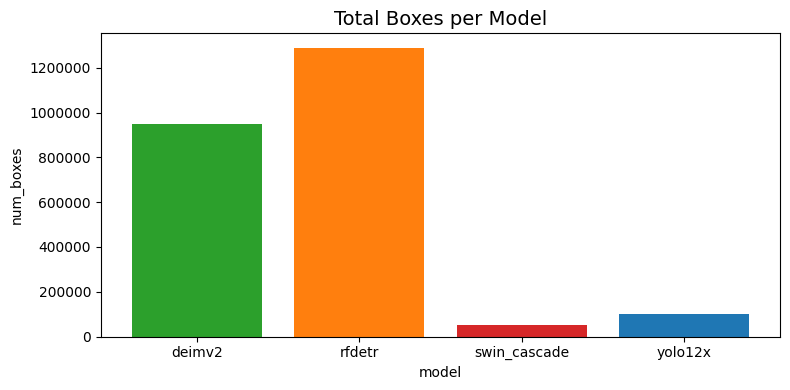

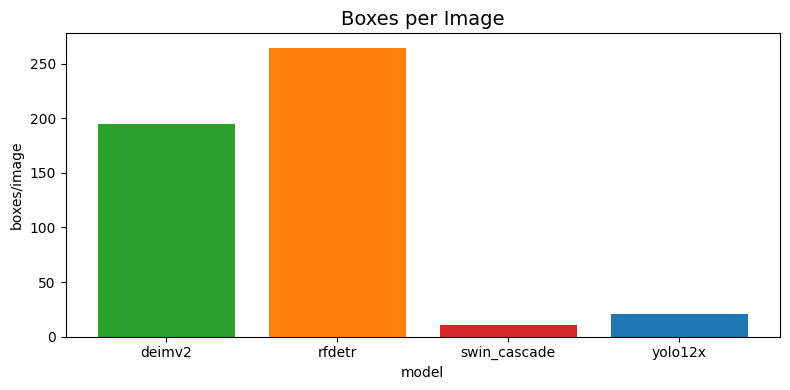

In [16]:
# =====================================
# 3. 기본 통계 (박스 수, 이미지당 박스 수)
# =====================================
model_dfs = {m: explode_predictions(path, m) for m, path in CSV_PATHS.items()}
all_boxes = pd.concat(model_dfs.values(), ignore_index=True)
all_boxes.head()

box_counts = all_boxes.groupby("model")["class_id"].count()
image_counts = all_boxes.groupby("model")["image_id"].nunique()

summary_basic = pd.DataFrame({
    "num_boxes": box_counts,
    "num_images": image_counts,
    "boxes_per_image": box_counts / image_counts
})

from IPython.display import display
print("📌 기본 통계 요약 (Summary Basic)")
display(summary_basic)

# ---- 시각화 ----
import matplotlib.pyplot as plt

# 모델별 통일된 색상 팔레트
model_colors = {
    "deimv2": "#2ca02c",       # 초록
    "rfdetr": "#ff7f0e",       # 주황
    "swin_cascade": "#d62728", # 빨강
    "yolo12x": "#1f77b4",     # 파랑
}

colors = [model_colors[m] for m in summary_basic.index]


# ----------------------------
# 1. 모델별 박스 수 (개별 출력)
# ----------------------------
plt.figure(figsize=(8, 4))
plt.bar(summary_basic.index, summary_basic["num_boxes"], color=colors)
plt.title("Total Boxes per Model", fontsize=14)
plt.ylabel("num_boxes")
plt.xlabel("model")
plt.ticklabel_format(axis="y", style="plain")
plt.tight_layout()
plt.show()


# ------------------------------------
# 2. 모델별 Boxes per Image (개별 출력)
# ------------------------------------
plt.figure(figsize=(8, 4))
plt.bar(summary_basic.index, summary_basic["boxes_per_image"], color=colors)
plt.title("Boxes per Image", fontsize=14)
plt.ylabel("boxes/image")
plt.xlabel("model")
plt.ticklabel_format(axis="y", style="plain")
plt.tight_layout()
plt.show()


📌 Pivot Count (Class-wise #boxes per model)


model       deimv2  rfdetr  swin_cascade  yolo12x
class_name                                       
0           251631  422811         11453    23999
1           152424  240087         13319    30065
2            42090   43458          1445     2069
3            84569   90289          2485     3848
4            36066   32663          2216     2807
5           134326  156828          7511    12176
6            44161   53534          2471     3905
7           161392  208798          9651    18774
8             7059   10090           211      294
9            37683   30977          1359     1677

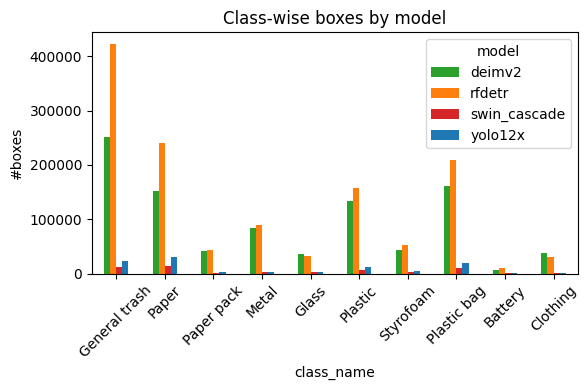

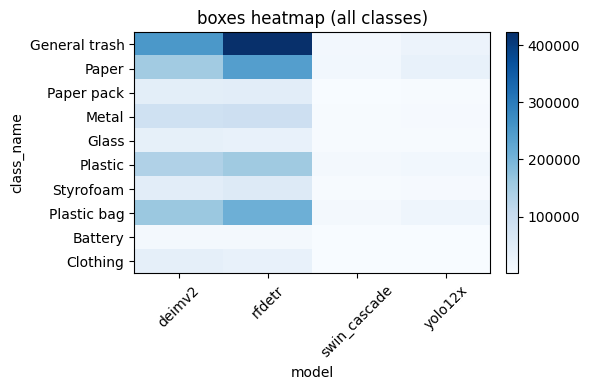

In [17]:
# ==========================
# 4. 클래스별 박스 수 분석 셀
# ==========================
all_boxes["class_name"] = all_boxes["class_id"].astype(str)

pivot_count = (
    all_boxes
    .groupby(["model", "class_name"])["class_id"]
    .count()
    .unstack("model")
    .fillna(0)
)

from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

print("📌 Pivot Count (Class-wise #boxes per model)")
display(pivot_count)

# --------------------------------------
# 🔹 class_id → class_name 매핑
# --------------------------------------
class_mapping = {
    "0": "General trash",
    "1": "Paper",
    "2": "Paper pack",
    "3": "Metal",
    "4": "Glass",
    "5": "Plastic",
    "6": "Styrofoam",
    "7": "Plastic bag",
    "8": "Battery",
    "9": "Clothing"
}

# pivot index를 클래스명으로 변경
pivot_count_named = pivot_count.copy()
pivot_count_named.index = pivot_count_named.index.map(class_mapping)

# 클래스 순서 리스트 생성 (0~9 순서 유지)
class_order = [class_mapping[str(i)] for i in range(10)]

bar_colors = [model_colors[m] for m in pivot_count.columns]


# --------------------------------------
# 1️⃣ 클래스별 #boxes bar plot — 단독 출력
# --------------------------------------
fig, ax1 = plt.subplots(figsize=(6, 4))

pivot_count_named.loc[class_order].plot(
    kind="bar",
    ax=ax1,
    color=bar_colors,
)
ax1.set_title("Class-wise boxes by model")
ax1.set_xlabel("class_name")
ax1.set_ylabel("#boxes")
ax1.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


# --------------------------------------
# 2️⃣ 클래스별 #boxes heatmap — 단독 출력
# --------------------------------------
fig, ax2 = plt.subplots(figsize=(6, 4))

im1 = ax2.imshow(
    pivot_count_named.loc[class_order].values,
    aspect="auto",
    cmap="Blues"
)

ax2.set_title("boxes heatmap (all classes)")
ax2.set_xlabel("model")
ax2.set_ylabel("class_name")

ax2.set_xticks(range(len(pivot_count.columns)))
ax2.set_xticklabels(pivot_count.columns, rotation=45)

ax2.set_yticks(range(len(class_order)))
ax2.set_yticklabels(class_order)

fig.colorbar(im1, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/ephemeral/home/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

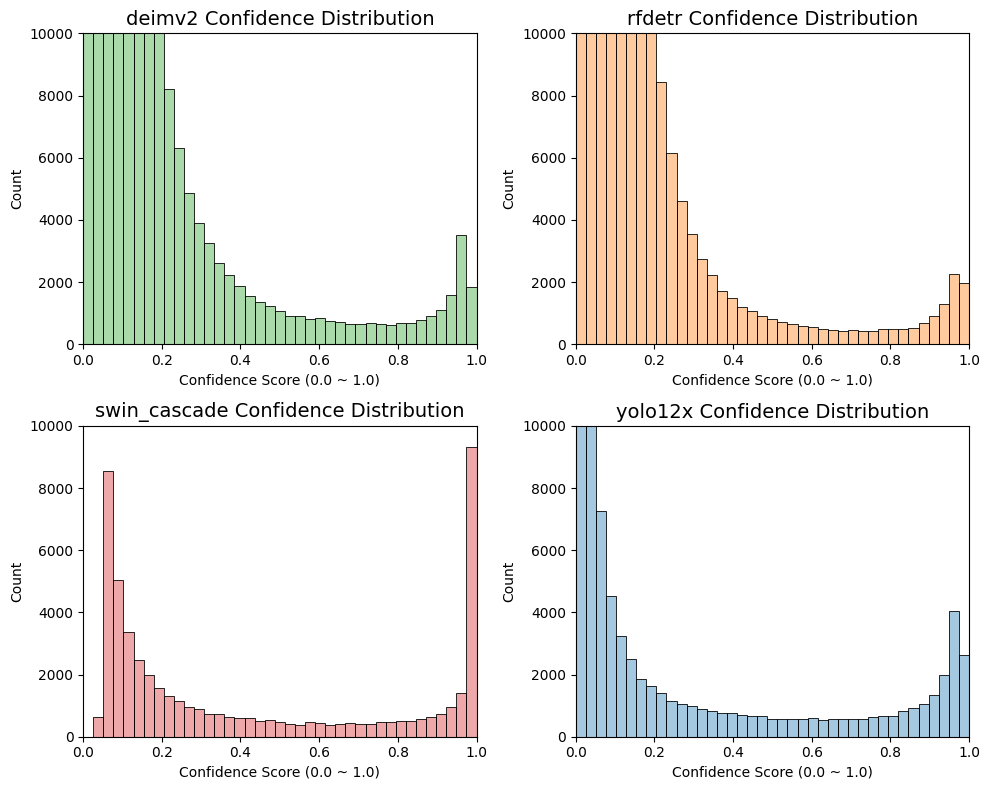

📌 Pivot Confidence (Class-wise mean confidence per model)


model         deimv2    rfdetr  swin_cascade   yolo12x
class_name                                            
0           0.070150  0.047470      0.358959  0.170129
1           0.095094  0.078421      0.414410  0.224238
2           0.057454  0.061859      0.491308  0.430931
3           0.051871  0.045761      0.424875  0.236305
4           0.057923  0.064522      0.444634  0.339188
5           0.066364  0.060685      0.413264  0.236401
6           0.069808  0.064946      0.449250  0.277751
7           0.080499  0.065286      0.543606  0.284697
8           0.041811  0.038205      0.619798  0.546249
9           0.047863  0.049124      0.448392  0.263864

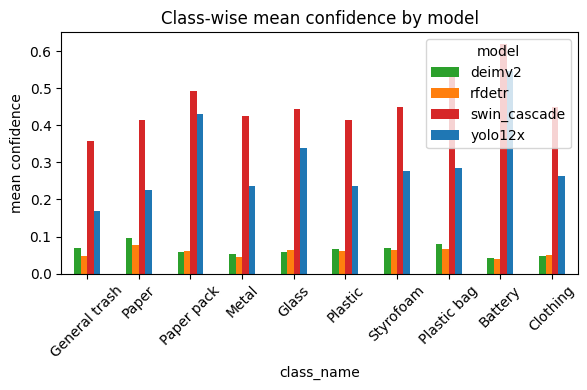

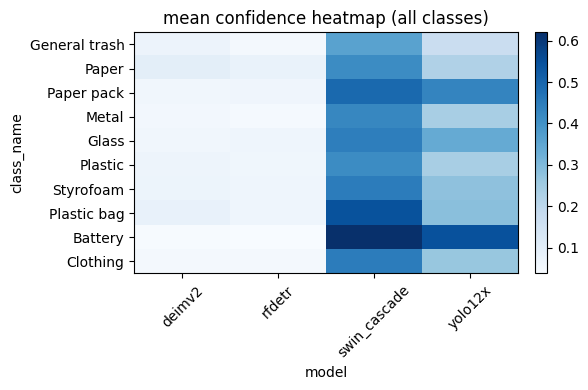

In [18]:
# ===============================
# 5. 클래스별 평균 confidence 분석
# ===============================

# ===============================
# 5-1) 모델별 Confidence Score 분포 히스토그램 (0.0 ~ 1.0)
# ===============================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use("default")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# 출력 순서
model_list = ["deimv2", "rfdetr", "swin_cascade", "yolo12x"]

for idx, model_name in enumerate(model_list):
    ax = axes[idx]

    df_m = model_dfs[model_name].copy()

    # 🔥 원본 confidence (0.0 ~ 1.0)
    scores = df_m["score"].astype(float)

    # 🔥 0~1 범위 40개 bin
    bins = np.linspace(0, 1.0, 40)

    sns.histplot(
        scores,
        bins=bins,
        kde=False,
        color=model_colors[model_name],
        alpha=0.4,
        ax=ax
    )

    ax.set_title(f"{model_name} Confidence Distribution", fontsize=14)
    ax.set_xlabel("Confidence Score (0.0 ~ 1.0)")
    ax.set_ylabel("Count")
    ax.set_xlim(0, 1.0)
    
    ax.set_ylim(0, 10000)

    # y축 숫자 scientific notation 제거
    ax.ticklabel_format(style="plain", axis="y")

plt.tight_layout()
plt.show()



# ----------------------------------------------
# 5-2) 모든 클래스 - 평균 confidence 표
# ----------------------------------------------
pivot_conf = (
    all_boxes
    .groupby(["model", "class_name"])["score"]
    .mean()
    .unstack("model")
)

from IPython.display import display
print("📌 Pivot Confidence (Class-wise mean confidence per model)")
display(pivot_conf)

# -------------------------------------------------
# 🔥 class_id → class_name 매핑
# -------------------------------------------------
class_mapping = {
    "0": "General trash",
    "1": "Paper",
    "2": "Paper pack",
    "3": "Metal",
    "4": "Glass",
    "5": "Plastic",
    "6": "Styrofoam",
    "7": "Plastic bag",
    "8": "Battery",
    "9": "Clothing",
}

# pivot index를 클래스명으로 변경
pivot_conf_named = pivot_conf.copy()
pivot_conf_named.index = pivot_conf_named.index.map(class_mapping)

# 클래스 순서 리스트 (0~9 순서 유지)
class_order = [class_mapping[str(i)] for i in range(10)]

bar_colors = [model_colors[m] for m in pivot_conf.columns]


# -------------------------------------------------
# 5-2) 평균 confidence bar plot — 클래스명 적용
# -------------------------------------------------
fig, ax1 = plt.subplots(figsize=(6, 4))

pivot_conf_named.loc[class_order].plot(
    kind="bar",
    ax=ax1,
    color=bar_colors,
)

ax1.set_title("Class-wise mean confidence by model")
ax1.set_xlabel("class_name")
ax1.set_ylabel("mean confidence")
ax1.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


# -------------------------------------------------
# 5-3) 평균 confidence heatmap — 클래스명 적용
# -------------------------------------------------
fig, ax2 = plt.subplots(figsize=(6, 4))

im2 = ax2.imshow(
    pivot_conf_named.loc[class_order].values,
    aspect="auto",
    cmap="Blues"
)

ax2.set_title("mean confidence heatmap (all classes)")
ax2.set_xlabel("model")
ax2.set_ylabel("class_name")

ax2.set_xticks(range(len(pivot_conf_named.columns)))
ax2.set_xticklabels(pivot_conf_named.columns, rotation=45)

ax2.set_yticks(range(len(class_order)))
ax2.set_yticklabels(class_order)

fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


<Figure size 800x500 with 0 Axes>

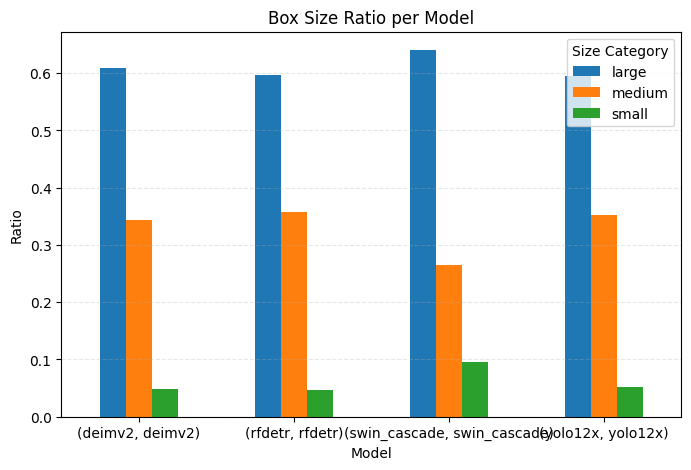

In [19]:
# ==========================================
# 6. small / medium / large 박스 비율 분석 셀
# ==========================================
size_dist = (
    all_boxes.groupby(["model", "size_category"])["class_id"]
    .count()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack()
)
size_dist

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
size_dist.plot(kind="bar", figsize=(8,5))

plt.title("Box Size Ratio per Model")
plt.xlabel("Model")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.legend(title="Size Category")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


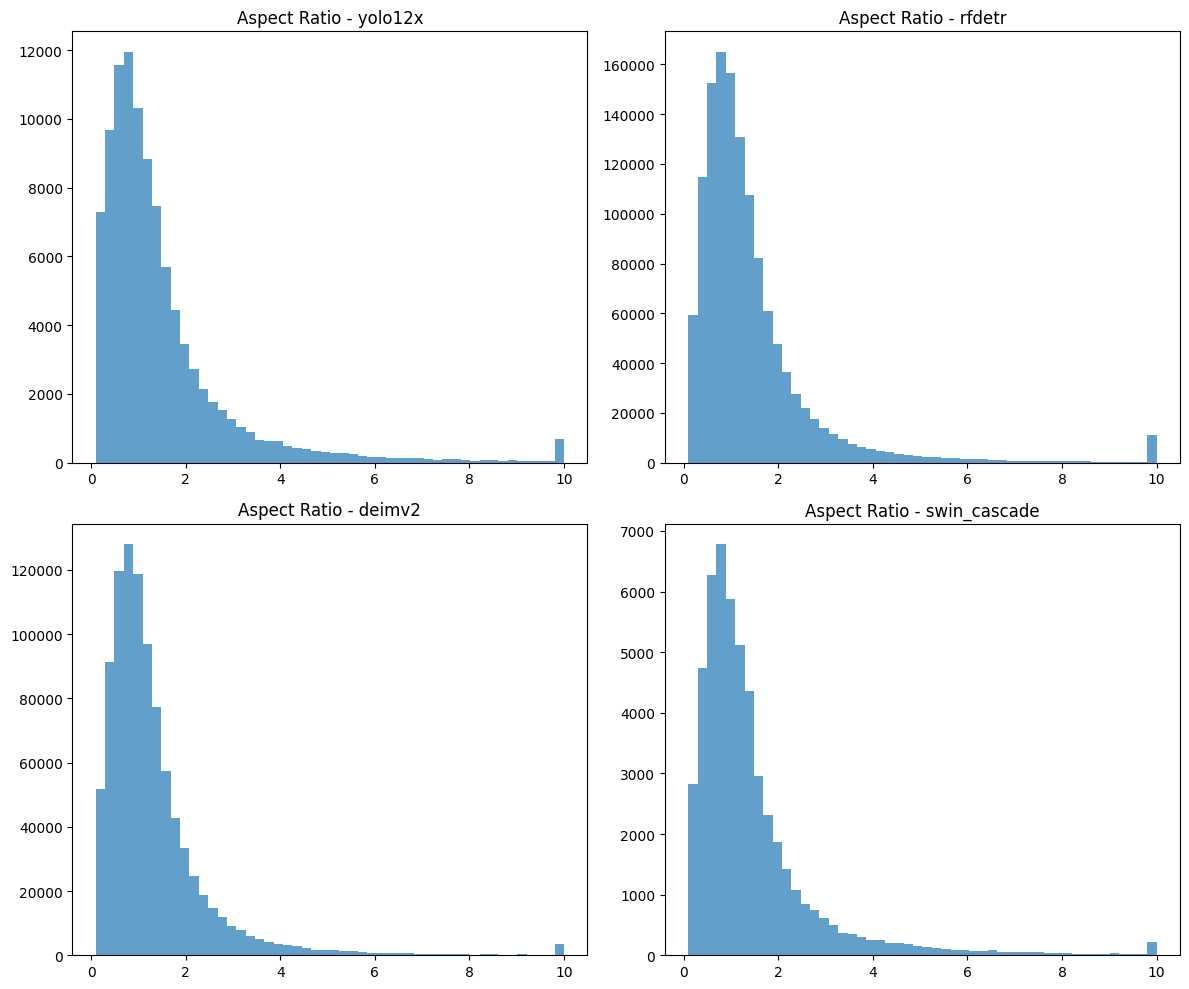

In [20]:
# ===========================================================
#7. 모델별 aspect ratio 분포 비교 - 탐지된 박스 가로&세로 비율
# ===========================================================
model_list = list(CSV_PATHS.keys())

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, model_name in enumerate(model_list):
    df_m = all_boxes[all_boxes["model"] == model_name]

    ax = axes[idx]
    ax.hist(df_m["aspect_ratio"].clip(0.1, 10), bins=50, alpha=0.7)
    ax.set_title(f"Aspect Ratio - {model_name}")

# 남는 subplot은 삭제
for i in range(len(model_list), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



In [21]:
# ============================================
# 8. 클래스 × 크기(size) × confidence 요약 통계
# ============================================
CLASS_MAPPING = {
    0: "General trash",
    1: "Paper",
    2: "Paper pack",
    3: "Metal",
    4: "Glass",
    5: "Plastic",
    6: "Styrofoam",
    7: "Plastic bag",
    8: "Battery",
    9: "Clothing"
}

agg_stats = (
    all_boxes.groupby(["model", "class_name", "size_category"])
    .agg(
        num_boxes=("score", "count"),
        mean_conf=("score", "mean"),
        median_conf=("score", "median"),
        q25=("score", lambda x: x.quantile(0.25)),
        q75=("score", lambda x: x.quantile(0.75)),
    )
    .reset_index()
)


agg_stats['class_name'] = agg_stats['class_name'].astype(int).map(CLASS_MAPPING)

pd.set_option('display.max_rows', None)     
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.max_colwidth', None) 

agg_stats.head()


model     class_name size_category  num_boxes  mean_conf  median_conf  \
0  deimv2  General trash         large     147564   0.070770       0.0361   
1  deimv2  General trash        medium      89780   0.072128       0.0405   
2  deimv2  General trash         small      14287   0.051310       0.0319   
3  deimv2          Paper         large      97603   0.102722       0.0442   
4  deimv2          Paper        medium      48235   0.084851       0.0498   

      q25     q75  
0  0.0191  0.0720  
1  0.0200  0.0839  
2  0.0178  0.0637  
3  0.0216  0.1018  
4  0.0237  0.1033

In [22]:
# ---------------------------------
# 8-1. agg_stats 전체 출력 (전체 표)
# ---------------------------------
print("--- 클래스 x 크기 x Confidence 요약 통계 전체 표 ---")
print(agg_stats)

--- 클래스 x 크기 x Confidence 요약 통계 전체 표 ---
            model     class_name size_category  num_boxes  mean_conf  \
0          deimv2  General trash         large     147564   0.070770   
1          deimv2  General trash        medium      89780   0.072128   
2          deimv2  General trash         small      14287   0.051310   
3          deimv2          Paper         large      97603   0.102722   
4          deimv2          Paper        medium      48235   0.084851   
5          deimv2          Paper         small       6586   0.057055   
6          deimv2     Paper pack         large      24884   0.061947   
7          deimv2     Paper pack        medium      15431   0.053088   
8          deimv2     Paper pack         small       1775   0.032418   
9          deimv2          Metal         large      43012   0.057145   
10         deimv2          Metal        medium      34583   0.048545   
11         deimv2          Metal         small       6974   0.035834   
12         deimv2      

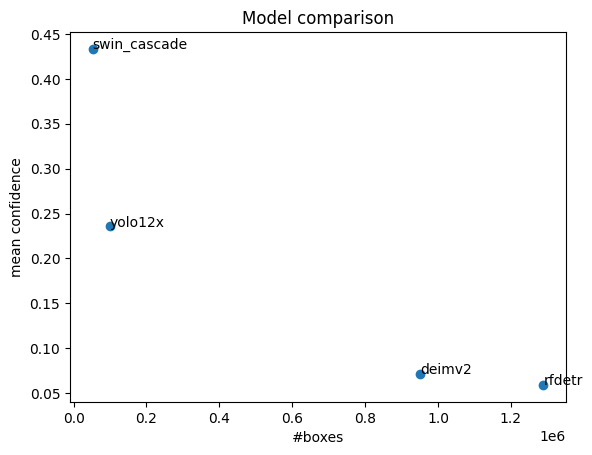

In [23]:
# =======================
# 9. 모델 간 scatter 비교
# ======================
model_conf_summary = (
    all_boxes.groupby("model")
    .agg(num_boxes=("class_id", "count"), mean_conf=("score", "mean"))
    .reset_index()
)

plt.scatter(model_conf_summary["num_boxes"], model_conf_summary["mean_conf"])
for _, row in model_conf_summary.iterrows():
    plt.text(row["num_boxes"], row["mean_conf"], row["model"])
plt.xlabel("#boxes")
plt.ylabel("mean confidence")
plt.title("Model comparison")
plt.show()


In [24]:
# # ===============================
# # 10. 모델 간 IoU Agreement 측정 (Top 50% confidence 사용)
# # ===============================

# # ===============================
# # 10-1) IoU 계산 유틸리티 함수
# # ===============================
# import numpy as np

# def compute_iou_matrix(boxes1, boxes2):
#     if len(boxes1) == 0 or len(boxes2) == 0:
#         return np.zeros((len(boxes1), len(boxes2)), dtype=np.float32)

#     b1 = boxes1[:, None, :]
#     b2 = boxes2[None, :, :]

#     x1 = np.maximum(b1[..., 0], b2[..., 0])
#     y1 = np.maximum(b1[..., 1], b2[..., 1])
#     x2 = np.minimum(b1[..., 2], b2[..., 2])
#     y2 = np.minimum(b1[..., 3], b2[..., 3])

#     inter_w = np.clip(x2 - x1, 0, None)
#     inter_h = np.clip(y2 - y1, 0, None)
#     inter_area = inter_w * inter_h

#     area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
#     area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

#     union = area1[:, None] + area2[None, :] - inter_area
#     return inter_area / (union + 1e-6)

# # ===============================
# # 10-1.5) 🔥 상위 50% Confidence 필터링 함수
# # ===============================
# def top_percent_boxes(df, percent=0.2):
#     thr = df["score"].quantile(1 - percent)  # 상위 percent 임계값
#     return df[df["score"] >= thr].copy()

# # ===============================
# # 10-2) 두 모델 간 IoU Agreement 계산
# # ===============================
# def iou_agreement_between_models(df_a, df_b, iou_thr=0.5, same_class=True):
#     imgs_a = df_a["image_id"].unique()
#     imgs_b = df_b["image_id"].unique()
#     common_imgs = np.intersect1d(imgs_a, imgs_b)

#     total_boxes_a = 0
#     matched_boxes_a = 0

#     for img_id in common_imgs:
#         a_img = df_a[df_a["image_id"] == img_id]
#         b_img = df_b[df_b["image_id"] == img_id]

#         if len(a_img) == 0 or len(b_img) == 0:
#             continue

#         total_boxes_a += len(a_img)

#         boxes_a = a_img[["x1", "y1", "x2", "y2"]].values.astype(np.float32)
#         boxes_b = b_img[["x1", "y1", "x2", "y2"]].values.astype(np.float32)

#         iou_mat = compute_iou_matrix(boxes_a, boxes_b)

#         if same_class:
#             cls_a = a_img["class_id"].values[:, None]
#             cls_b = b_img["class_id"].values[None, :]
#             iou_mat[cls_a != cls_b] = 0.0

#         best_iou = iou_mat.max(axis=1)
#         matched_boxes_a += (best_iou >= iou_thr).sum()

#     if total_boxes_a == 0:
#         return 0.0

#     return (matched_boxes_a / total_boxes_a) * 100.0


# # ===============================
# # 10-3) 4개 모델 전체 쌍 IoU Agreement 계산 (Top 50% 사용)
# # ===============================

# model_order = ["deimv2", "rfdetr", "swin_cascade", "yolo12x"]

# # 🔥 각 모델의 상위 50% 박스를 먼저 필터링해둔다
# model_top20 = {
#     m: top_percent_boxes(model_dfs[m], percent=0.2)
#     for m in model_order
# }

# iou_thr = 0.5
# iou_agree_dict = {}

# for i in range(len(model_order)):
#     for j in range(i + 1, len(model_order)):
#         m1, m2 = model_order[i], model_order[j]

#         df1 = model_top20[m1]
#         df2 = model_top20[m2]

#         agree = iou_agreement_between_models(
#             df1, df2,
#             iou_thr=iou_thr,
#             same_class=True,
#         )

#         iou_agree_dict[f"{m1}-{m2}"] = agree

# iou_agree_dict


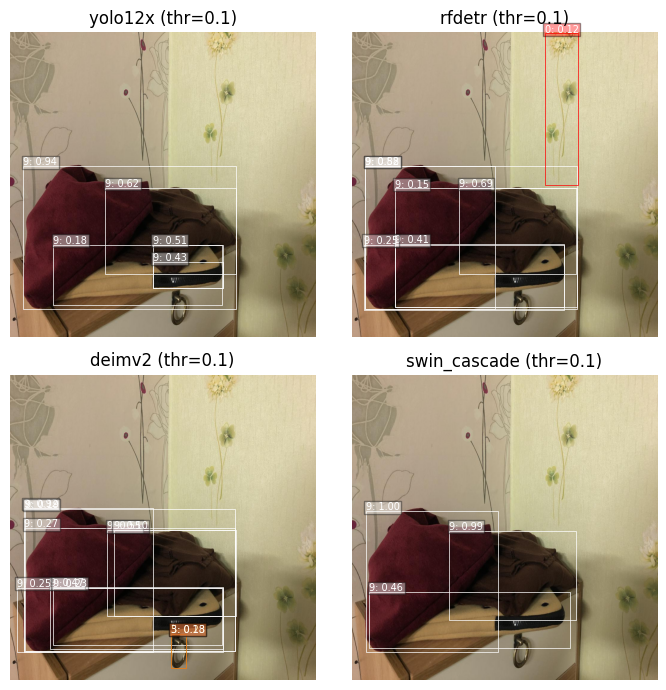

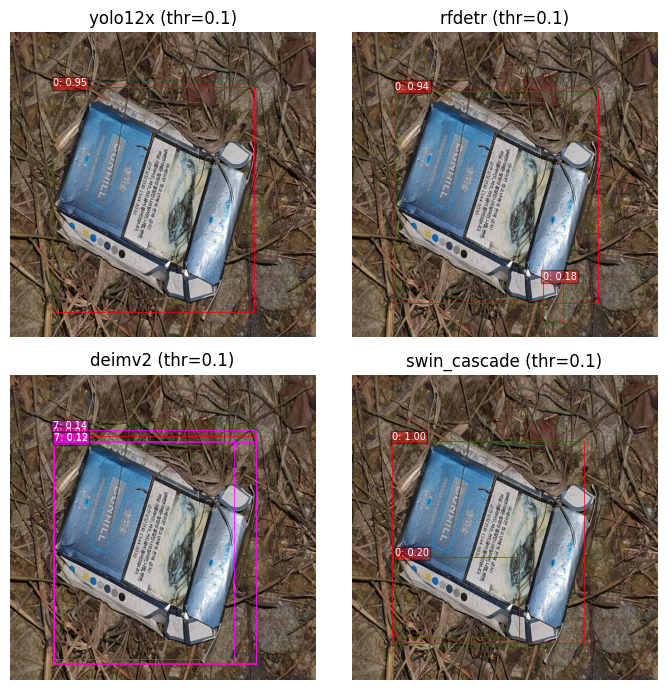

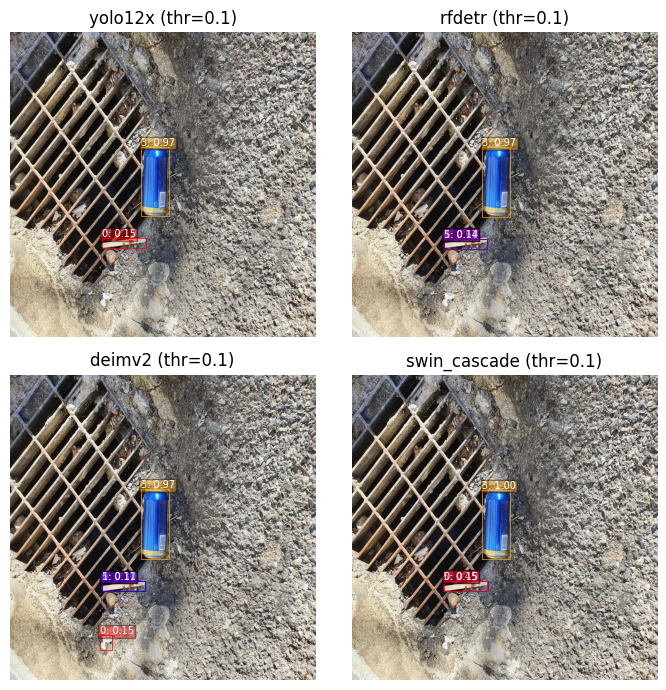

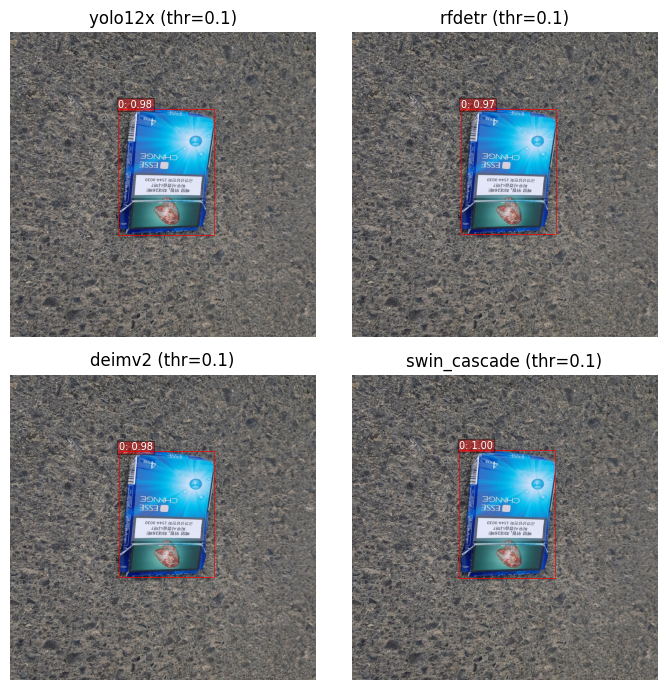

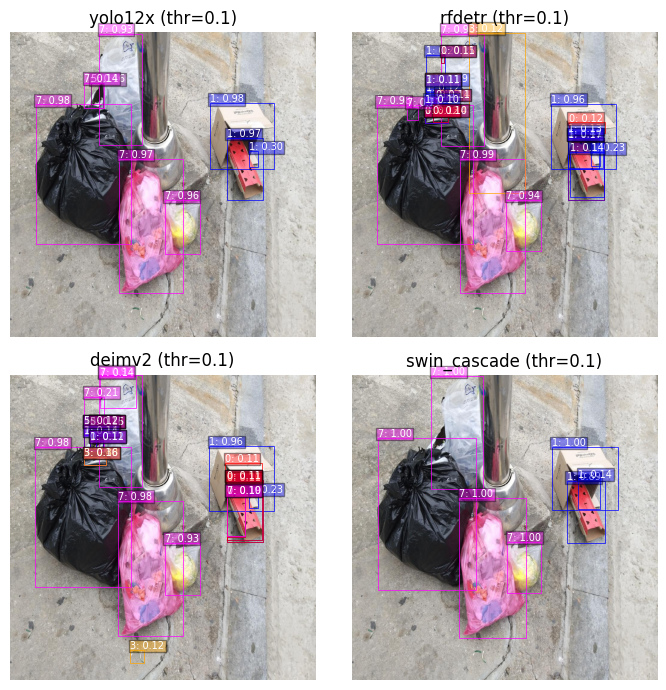

In [25]:
# ==========================================================
# 11. 테스트 이미지에 각 모델의 박스 시각화 - 4개 모델 모두 시각화
# ===========================================================

# 클래스 ID → 클래스 이름
CLASS_NAMES = {
    0: "General trash",
    1: "Paper",
    2: "Paper pack",
    3: "Metal",
    4: "Glass",
    5: "Plastic",
    6: "Styrofoam",
    7: "Plastic bag",
    8: "Battery",
    9: "Clothing",
}

# 클래스 이름 → 색상
CLASS_COLORS = {
    "General trash": "red",
    "Paper": "blue",
    "Paper pack": "green",
    "Metal": "orange",
    "Glass": "yellow",
    "Plastic": "purple",
    "Styrofoam": "cyan",
    "Plastic bag": "magenta",
    "Battery": "lime",
    "Clothing": "white",
}

TEST_IMG_ROOT = "/data/ephemeral/home/dataset"
# %%
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# -------------------
# 4개 모델 모두 시각화
# ------------------
def show_detections_all_models(image_id, model_list=None, score_thr=0.3, figsize=(7, 7)):
    if model_list is None:
        model_list = list(model_dfs.keys())

    img_path = os.path.join(TEST_IMG_ROOT, image_id)
    img = Image.open(img_path).convert("RGB")

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()

    for idx, model_name in enumerate(model_list):
        df = model_dfs[model_name]
        df_img = df[(df["image_id"] == image_id) & (df["score"] >= score_thr)]

        ax = axes[idx]
        ax.imshow(img)
        ax.set_title(f"{model_name} (thr={score_thr})")
        ax.axis("off")

        for _, row in df_img.iterrows():
            cls_id = int(row["class_id"])
            cls_name = CLASS_NAMES[cls_id]
            color = CLASS_COLORS[cls_name]

            x1, y1, x2, y2 = row["x1"], row["y1"], row["x2"], row["y2"]
            w, h = x2 - x1, y2 - y1
            score = float(row["score"])

            rect = patches.Rectangle(
                (x1, y1),
                w, h,
                linewidth=0.5,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)

            ax.text(
                x1,
                y1 - 3,
                f"{cls_id}: {score:.2f}",   # ← 여기 cls_id 로 변경
                fontsize=7,
                color="white",
                bbox=dict(facecolor=color, alpha=0.4, pad=1),
            )

    # 남는 subplot 제거
    for j in range(len(model_list), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
# 4개 모델 비교
for i in range(70, 75):
    img_id = f"test/{i:04d}.jpg"
    show_detections_all_models(img_id, score_thr=0.1)

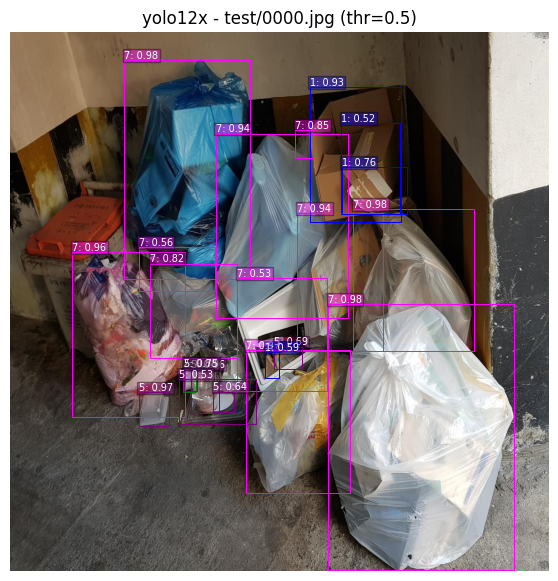

In [26]:
# ====================
# 11. 단일모델 시각화
# ====================
def show_detections_single_model(image_id, model_name, score_thr=0.3, figsize=(7, 7)):
    df_model = model_dfs[model_name]
    df_img = df_model[(df_model["image_id"] == image_id) & (df_model["score"] >= score_thr)]

    img_path = os.path.join(TEST_IMG_ROOT, image_id)
    img = Image.open(img_path).convert("RGB")

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img)
    ax.set_title(f"{model_name} - {image_id} (thr={score_thr})")
    ax.axis("off")

    for _, row in df_img.iterrows():
        cls_id = int(row["class_id"])
        cls_name = CLASS_NAMES[cls_id]
        color = CLASS_COLORS[cls_name]

        x1, y1, x2, y2 = row["x1"], row["y1"], row["x2"], row["y2"]
        w, h = x2 - x1, y2 - y1
        score = float(row["score"])

        rect = patches.Rectangle(
            (x1, y1),
            w, h,
            linewidth=0.7,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)

        ax.text(
            x1,
            y1 - 3,
            f"{cls_id}: {score:.2f}",   # ← 여기 cls_id 로 변경
            fontsize=7,
            color="white",
            bbox=dict(facecolor=color, alpha=0.4, pad=1),
        )

    plt.show()

# 단일 모델 시각화
show_detections_single_model("test/0000.jpg", "yolo12x", score_thr=0.5)

